In [134]:
import face_recognition as fr
from skimage import io as io
from matplotlib import pyplot as plt
import numpy as np
import cv2

import math

In [744]:
def face_alignment(img, scale=1, face_size=(256,256)):
    '''
    face alignment API for single image, get the landmark of eyes and nose and do warpaffine transformation
    :param face_img: single image that including face, I recommend to use dlib frontal face detector
    :param scale: scale factor to judge the output image size

    :return: an aligned single face image
    '''
    h, w, c = img.shape
    output_img = list()
    face_loc_list = _face_locations_small(img)
    for face_loc in face_loc_list:
        face_img = _crop_face(img, face_loc, padding_size=int((face_loc[2] - face_loc[0])*0.5)) # 얼굴 부분 짜르기
        face_loc_small_img = _face_locations_small(face_img)
        face_land = fr.face_landmarks(face_img, face_loc_small_img)
        print('-------------------------------')
        print(face_land)
        print('-------------------------------')
        if len(face_land) == 0:
            return []
        left_eye_center = _find_center_pt(face_land[0]['left_eye']) # 왼쪽눈, 오른쪽눈, 코를 찾아서 회전시킴
        right_eye_center = _find_center_pt(face_land[0]['right_eye'])
        nose_center = _find_center_pt(face_land[0]['nose_tip'])
        trotate = _get_rotation_matrix(left_eye_center, right_eye_center, nose_center, img, scale=scale)
        warped = cv2.warpAffine(face_img, trotate, (w, h))
        new_face_loc = fr.face_locations(warped)
        if len(new_face_loc) == 0:
            return []
        output_img.append(cv2.resize(_crop_face(warped, new_face_loc[0]), face_size))

    return output_img, face_land

In [745]:
def _find_center_pt(points):
    '''
    find centroid point by several points that given
    '''
    x = 0
    y = 0
    num = len(points)
    for pt in points:
        x += pt[0]
        y += pt[1]
    x //= num
    y //= num
    return (x,y)

def _angle_between_2_pt(p1, p2):
    '''
    to calculate the angle rad by two points
    '''
    x1, y1 = p1
    x2, y2 = p2
    tan_angle = (y2 - y1) / (x2 - x1)
    return (np.degrees(np.arctan(tan_angle)))

def _get_rotation_matrix(left_eye_pt, right_eye_pt, nose_center, face_img, scale):
    '''
    to get a rotation matrix by using skimage, including rotate angle, transformation distance and the scale factor
    '''
    eye_angle = _angle_between_2_pt(left_eye_pt, right_eye_pt)
    M = cv2.getRotationMatrix2D((nose_center[0]/2, nose_center[1]/2), eye_angle, scale )

    return M

def _dist_nose_tip_center_and_img_center(nose_pt, img_shape):
    '''
    find the distance between nose tip's centroid and the centroid of original image
    '''
    y_img, x_img, _ = img_shape
    img_center = (x_img//2, y_img//2)
    return ((img_center[0] - nose_pt[0]), -(img_center[1] - nose_pt[1]))

def _crop_face(img, face_loc, padding_size=30):
    '''
    crop face into small image, face only, but the size is not the same
    '''
    h, w, c = img.shape
    top = face_loc[0] - padding_size
    right = face_loc[1] + padding_size
    down = face_loc[2] + padding_size
    left = face_loc[3] - padding_size

    if top < 0:
        top = 0
    if right > w - 1:
        right = w - 1
    if down > h - 1:
        down = h - 1
    if left < 0:
        left = 0
    img_crop = img[top:down, left:right]
    return img_crop

def _face_locations_raw(img, scale):
#     img_scale = (tf.resize(img, (img.shape[0]//scale, img.shape[1]//scale)) * 255).astype(np.uint8)
    h, w, c = img.shape
    img_scale = cv2.resize(img, (int(img.shape[1]//scale), int(img.shape[0]//scale)))
    face_loc_small = fr.face_locations(img_scale)
    face_loc = []
    for ff in face_loc_small:
        tmp = [pt*scale for pt in ff]
        if tmp[1] >= w:
            tmp[1] = w
        if tmp[2] >= h:
            tmp[2] = h
        face_loc.append(tmp)
    return face_loc

def _face_locations_small(img):
    for scale in [16, 8, 4, 2, 1]:
        face_loc = _face_locations_raw(img, scale)
        print("face_loc = ",face_loc)
        if face_loc != []:
            return face_loc
    return []

face_loc =  []
face_loc =  [[112, 424, 400, 136]]
face_loc =  []
face_loc =  [[112, 424, 400, 136]]
-------------------------------
[{'chin': [(204, 251), (203, 274), (206, 298), (212, 322), (222, 346), (239, 368), (259, 388), (283, 405), (306, 409), (330, 402), (355, 386), (376, 366), (394, 344), (405, 318), (407, 290), (406, 261), (405, 232)], 'left_eyebrow': [(206, 231), (214, 217), (230, 211), (247, 211), (263, 215)], 'right_eyebrow': [(289, 211), (308, 203), (329, 200), (349, 203), (366, 212)], 'nose_bridge': [(281, 235), (281, 254), (280, 272), (280, 290)], 'nose_tip': [(268, 304), (277, 306), (287, 308), (297, 303), (306, 299)], 'left_eye': [(225, 245), (235, 241), (246, 240), (258, 244), (247, 244), (236, 244)], 'right_eye': [(311, 238), (320, 231), (331, 229), (345, 231), (333, 232), (322, 235)], 'top_lip': [(255, 334), (265, 324), (280, 321), (293, 323), (306, 318), (327, 318), (347, 322), (343, 323), (308, 327), (294, 331), (281, 331), (259, 333)], 'bottom_lip': [(347, 322),

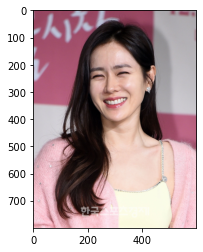

After alignment


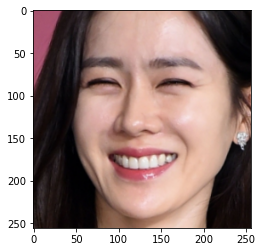

In [772]:
image = io.imread('img7/3.jpg')
result, face_land = face_alignment(image, scale = 1.02)
face = result[0]
print('Original image')
plt.imshow(image)
plt.show()

print('After alignment')
plt.imshow(face)
plt.show()

In [773]:
face_land

[{'chin': [(204, 251),
   (203, 274),
   (206, 298),
   (212, 322),
   (222, 346),
   (239, 368),
   (259, 388),
   (283, 405),
   (306, 409),
   (330, 402),
   (355, 386),
   (376, 366),
   (394, 344),
   (405, 318),
   (407, 290),
   (406, 261),
   (405, 232)],
  'left_eyebrow': [(206, 231), (214, 217), (230, 211), (247, 211), (263, 215)],
  'right_eyebrow': [(289, 211),
   (308, 203),
   (329, 200),
   (349, 203),
   (366, 212)],
  'nose_bridge': [(281, 235), (281, 254), (280, 272), (280, 290)],
  'nose_tip': [(268, 304), (277, 306), (287, 308), (297, 303), (306, 299)],
  'left_eye': [(225, 245),
   (235, 241),
   (246, 240),
   (258, 244),
   (247, 244),
   (236, 244)],
  'right_eye': [(311, 238),
   (320, 231),
   (331, 229),
   (345, 231),
   (333, 232),
   (322, 235)],
  'top_lip': [(255, 334),
   (265, 324),
   (280, 321),
   (293, 323),
   (306, 318),
   (327, 318),
   (347, 322),
   (343, 323),
   (308, 327),
   (294, 331),
   (281, 331),
   (259, 333)],
  'bottom_lip': [(347

In [774]:
import dlib
detector = dlib.get_frontal_face_detector()   # dlib을 활용해 detector 선언

In [775]:
model_path = 'shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [791]:
landmark_predictor

In [776]:
dets = detector(face, 1)

In [777]:
print("Number of faces detected: {}".format(len(dets)))

Number of faces detected: 1


In [778]:
dets

rectangles[[(35, 36) (221, 222)]]

In [779]:
for k, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(k, d.left(), d.top(), d.right(), d.bottom()))
    
    shape = landmark_predictor(face, d)
    list_points = list(map(lambda p: (p.x, p.y), shape.parts()))    
    

Detection 0: Left: 35 Top: 36 Right: 221 Bottom: 222


In [780]:
#list_points

In [781]:
print(len(list_points))

68


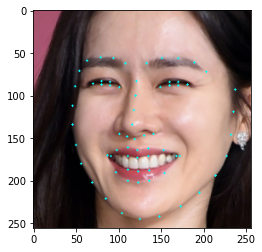

In [782]:
img = face.copy()
for point in list_points:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    plt.imshow(point_img)
    final_img = point_img

In [783]:
face_land[0]

{'chin': [(204, 251),
  (203, 274),
  (206, 298),
  (212, 322),
  (222, 346),
  (239, 368),
  (259, 388),
  (283, 405),
  (306, 409),
  (330, 402),
  (355, 386),
  (376, 366),
  (394, 344),
  (405, 318),
  (407, 290),
  (406, 261),
  (405, 232)],
 'left_eyebrow': [(206, 231), (214, 217), (230, 211), (247, 211), (263, 215)],
 'right_eyebrow': [(289, 211), (308, 203), (329, 200), (349, 203), (366, 212)],
 'nose_bridge': [(281, 235), (281, 254), (280, 272), (280, 290)],
 'nose_tip': [(268, 304), (277, 306), (287, 308), (297, 303), (306, 299)],
 'left_eye': [(225, 245),
  (235, 241),
  (246, 240),
  (258, 244),
  (247, 244),
  (236, 244)],
 'right_eye': [(311, 238),
  (320, 231),
  (331, 229),
  (345, 231),
  (333, 232),
  (322, 235)],
 'top_lip': [(255, 334),
  (265, 324),
  (280, 321),
  (293, 323),
  (306, 318),
  (327, 318),
  (347, 322),
  (343, 323),
  (308, 327),
  (294, 331),
  (281, 331),
  (259, 333)],
 'bottom_lip': [(347, 322),
  (332, 344),
  (314, 358),
  (299, 362),
  (285, 

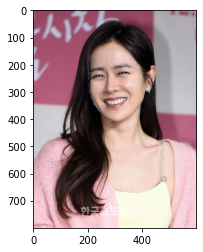

In [784]:
img = image.copy()
for point in face_land[0]['chin']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['left_eyebrow']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['right_eyebrow']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['nose_bridge']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['nose_tip']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['left_eye']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['right_eye']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
        
for point in face_land[0]['top_lip']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    
for point in face_land[0]['bottom_lip']:
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    plt.imshow(point_img)

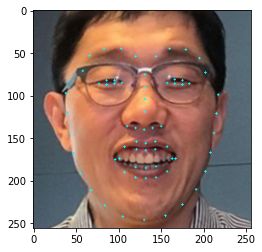

In [759]:
plt.imshow(final_img)
plt.show()

39-42 미간  
36-39 왼쪽 눈(사진상)  
42-45 오른쪽 눈(사진상)  
37-41, 38-40 왼쪽 눈 세로 길이  
43-47, 44-46 오른쪽 눈 세로 길이  
17-21 왼쪽 눈썹  
22-26 오른쪽 눈썹  
31-35 콧볼 가로 길이  
27-30 코 길이  
48-54 입술 가로 길이  
51-62+66-57 입술 세로 길이  
33-51 인중길이  
33-8 하관 길이  
1-15 머리 너비 길이  
? 머리 수직 길이  

(104, 85)
104


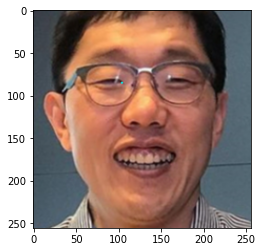

In [760]:
img = face.copy()
x = 39
for point in list_points[x:x+1]:
    print(point)
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    plt.imshow(point_img)
    final_img = point_img
    
print(list_points[x:x+1][0][0])

(157, 85)
157


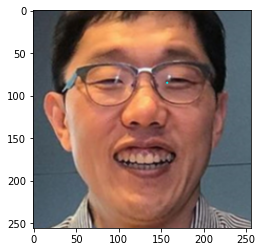

In [761]:
img = face.copy()
x = 42
for point in list_points[x:x+1]:
    print(point)
    point_img = cv2.circle(img, point, 1, (0, 255, 255), -1)
    plt.imshow(point_img)
    final_img = point_img
    
print(list_points[x:x+1][0][0])

In [762]:
def length(x, y):
    a = list_points[x:x+1][0][0] - list_points[y:y+1][0][0]
    b = list_points[x:x+1][0][1] - list_points[y:y+1][0][1]
    #print("(", a, ",", b, ")")

    c = math.sqrt(pow(a,2) + pow(b,2))
    #print(c)
    return round(c, 2)

In [763]:
def length_float(x, y):
    a = list_points[x:x+1][0][0] - list_points[y:y+1][0][0]
    b = list_points[x:x+1][0][1] - list_points[y:y+1][0][1]
    #print("(", a, ",", b, ")")

    c = math.sqrt(pow(a,2) + pow(b,2))
    #print(c)
    return c

In [764]:
def makelist(name, x, y):
    info.append({'name': name, 'x' : x, 'y' : y, 'len': length(x, y)})
    return info

In [765]:
info = []
info = makelist('1', 39, 42)
info = makelist('2', 36, 39)
info = makelist('3', 42, 45)
info = makelist('4', 37, 41)
info = makelist('5', 38, 40)
info = makelist('6', 43, 47)
info = makelist('7', 44, 46)
info = makelist('8', 17, 21)
info.append({'name': '9', 'x' : 17, 'y' : 21, 'len': length(17,18) + length(18,19) + length(19,20) + length(20,21)})
info = makelist('10', 22, 26)
info.append({'name': '11', 'x' : 22, 'y' : 26, 'len': length(22,23) + length(23,24) + length(24,25) + length(25,26)})
info = makelist('12', 31, 35)
info = makelist('13', 27, 30)
info = makelist('14', 48, 54)
info.append({'name': '15', 'x' : 51, 'y' : 57, 'len': length(51,62)+length(66,57)})
info = makelist('16', 51, 57)
info = makelist('17', 33, 51)
info = makelist('18', 33, 8)
info = makelist('19', 1,15)
print(len(info))

19


In [766]:

# 39-42 미간
print("1.미간 길이 : ", length(39,42))

# 36-39 왼쪽 눈(사진상)
print("\n2.왼쪽 눈 길이 : ", length(36,39))

# 42-45 오른쪽 눈(사진상)
print("\n3.오른쪽 눈 길이 : ", length(42,45))

#37-41 왼쪽 눈 세로 길이
print("\n4.왼쪽 눈 세로 길이 : ", length(37,41))
print("5.왼쪽 눈 세로 길이 : ", length(38,40))

#37-41 오른쪽 눈 세로 길이
print("\n6.오른쪽 눈 세로 길이 : ", length(43,47))
print("7.오른쪽 눈 세로 길이 : ", length(44,46))

#17-21 왼쪽 눈썹 길이
print("\n8.왼쪽 눈썹 길이(끝과 끝) : ", length(17,21))
#모든 점 사이 길이 계산
print("9.왼쪽 눈썹 길이(사이계산) : ", length(17,18) + length(18,19) + length(19,20) + length(20,21))

#22-26 오른쪽 눈썹 길이
print("\n10.오른쪽 눈썹 길이 : ", length(22,26))
#모든 점 사이 길이 계산
print("11.오른쪽 눈썹 길이(사이계산) : ", length(22,23) + length(23,24) + length(24,25) + length(25,26))

#31-35 콧볼 가로 길이
print("\n12.콧볼 가로 길이 : ", length(31,35))

#27-30 코 길이
print("\n13.코 길이 : ", length(27,30))

#48-54 입술 가로 길이
print("\n14.입술 가로 길이 : ", length(48,54))

#51-62+66-57 입술 세로 길이
print("\n15.입술 세로 길이 : ", length(51,62)+length(66,57))
#다물었다고 가정하면 51-57
print("\n16.다문 입술 세로 길이 : ", length(51,57))

#33-51 인중길이
print("\n17.인중길이 : ", length(33,51))

#33-8 하관 길이
print("\n18.하관 길이 : ", length(33,8))

#1-15 머리 너비 길이
print("\n19.머리 너비 길이 : ", length(1,15))

1.미간 길이 :  53.0

2.왼쪽 눈 길이 :  27.02

3.오른쪽 눈 길이 :  26.02

4.왼쪽 눈 세로 길이 :  5.0
5.왼쪽 눈 세로 길이 :  4.0

6.오른쪽 눈 세로 길이 :  5.0
7.오른쪽 눈 세로 길이 :  5.0

8.왼쪽 눈썹 길이(끝과 끝) :  64.29
9.왼쪽 눈썹 길이(사이계산) :  77.72999999999999

10.오른쪽 눈썹 길이 :  61.03
11.오른쪽 눈썹 길이(사이계산) :  74.64

12.콧볼 가로 길이 :  40.0

13.코 길이 :  44.0

14.입술 가로 길이 :  71.01

15.입술 세로 길이 :  20.0

16.다문 입술 세로 길이 :  41.0

17.인중길이 :  16.12

18.하관 길이 :  106.0

19.머리 너비 길이 :  175.0


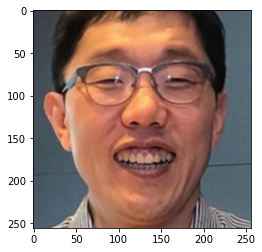

In [767]:
plt.imshow(face)

In [768]:
check_img = face.copy()

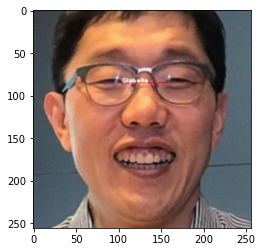

In [769]:
check_img = face.copy()
start = 39
end = 42
cv2.line(check_img, list_points[start], list_points[end], (255,0,0))
cv2.putText(check_img, "Glabella", list_points[start], cv2.FONT_HERSHEY_PLAIN, 0.5, (255,255,255), 1, cv2.LINE_AA)
plt.imshow(check_img)

In [770]:
def output(name, start, end, length) :
    cv2.line(check_img, list_points[start], list_points[end], (255,0,0))
    cv2.putText(check_img, str(length), list_points[start], cv2.FONT_HERSHEY_PLAIN, 0.5, (255,255,255), 0, cv2.LINE_AA)

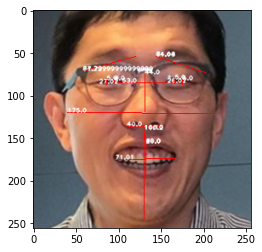

In [771]:
check_img = face.copy()
for i in info:
    output(i['name'], i['x'], i['y'], i['len'])
plt.imshow(check_img)    